In [1]:
# ======================================
# 📦 1. IMPORT LIBRARY
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# ======================================
# 📂 2. LOAD & CEK DATA
# ======================================
df = pd.read_csv('/content/drive/MyDrive/Proyek Data Mining/Project Kecil/Data_Penjualan_dan_Pajak_BBM_di_DKI_Jakarta.csv')  # Ganti path sesuai file kamu
print(df.head())
print(df.info())

   bulan stasiun_pengisian_bahanbakar jenis_bahanbakar  jumlah_penjualan  \
0      8                    Pertamina        Pertalite          33509222   
1      8                    Pertamina         Pertamax          52850550   
2      8                    Pertamina    Pertamax Plus           2413000   
3      8                    Pertamina    Pertamina Dex           2468000   
4      8                    Pertamina          Dexlite           1094000   

   penerimaan_pajak  periode_data  
0       10052766600          2016  
1       16888563417          2016  
2         865532573          2016  
3         873780207          2016  
4         306795657          2016  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   bulan                         360 non-null    int64 
 1   stasiun_pengisian_bahanbakar  360 non-null  

In [3]:
print(df.head(10))

   bulan stasiun_pengisian_bahanbakar jenis_bahanbakar  jumlah_penjualan  \
0      8                    Pertamina        Pertalite          33509222   
1      8                    Pertamina         Pertamax          52850550   
2      8                    Pertamina    Pertamax Plus           2413000   
3      8                    Pertamina    Pertamina Dex           2468000   
4      8                    Pertamina          Dexlite           1094000   
5      8                    Pertamina  Pertamax Racing             16000   
6      8                    Pertamina              BBG             50246   
7      8                    Pertamina   Pertamax Turbo           1508000   
8      8                        Total   Performance 92           1354611   
9      8                        Total   Performance 95            224000   

   penerimaan_pajak  periode_data  
0       10052766600          2016  
1       16888563417          2016  
2         865532573          2016  
3         873780207

In [4]:
print(df.isnull().sum())

bulan                           0
stasiun_pengisian_bahanbakar    0
jenis_bahanbakar                0
jumlah_penjualan                0
penerimaan_pajak                0
periode_data                    0
dtype: int64


In [5]:
df.rename(columns={'periode_data': 'Tahun'}, inplace=True)
df.rename(columns={'stasiun_pengisian_bahanbakar': 'Lokasi'}, inplace=True)

In [6]:
print(df.head())

   bulan     Lokasi jenis_bahanbakar  jumlah_penjualan  penerimaan_pajak  \
0      8  Pertamina        Pertalite          33509222       10052766600   
1      8  Pertamina         Pertamax          52850550       16888563417   
2      8  Pertamina    Pertamax Plus           2413000         865532573   
3      8  Pertamina    Pertamina Dex           2468000         873780207   
4      8  Pertamina          Dexlite           1094000         306795657   

   Tahun  
0   2016  
1   2016  
2   2016  
3   2016  
4   2016  


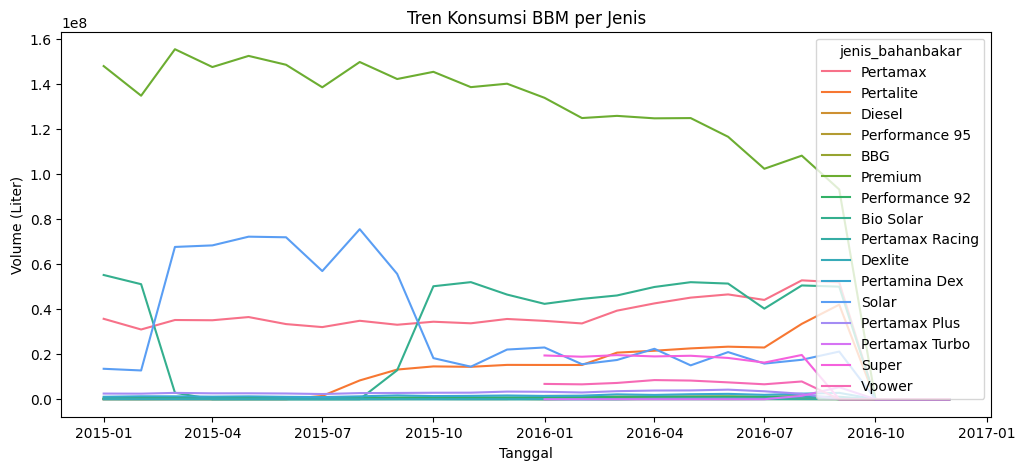

In [7]:
# ======================================
# 🔍 3. EDA (EXPLORATORY DATA ANALYSIS)
# ======================================
# Cek tren konsumsi BBM secara umum
df['tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + '-' + df['bulan'].astype(str) + '-01')
df.sort_values('tanggal', inplace=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='tanggal', y='jumlah_penjualan', hue='jenis_bahanbakar')
plt.title('Tren Konsumsi BBM per Jenis')
plt.xlabel('Tanggal')
plt.ylabel('Volume (Liter)')
plt.show()

In [8]:
# ======================================
# 🧼 4. DATA PREPROCESSING
# ======================================
df['tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + '-' + df['bulan'].astype(str) + '-01')
df.sort_values('tanggal', inplace=True)

# Filter Pertalite saja
df_plt = df[df['jenis_bahanbakar'].str.lower() == 'pertalite']
data = df_plt[['tanggal', 'jumlah_penjualan']].set_index('tanggal').asfreq('MS')

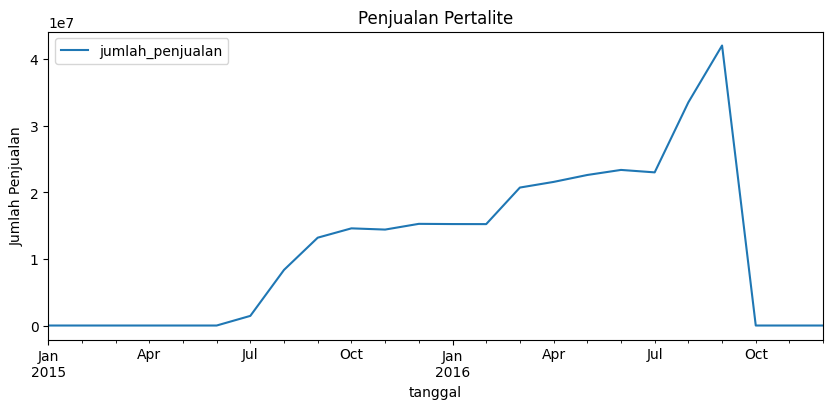

In [9]:
# 5.Visualisasi awal
data.plot(figsize=(10,4), title='Penjualan Pertalite')
plt.ylabel('Jumlah Penjualan')
plt.show()

In [10]:
# 6.Normalisasi
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [11]:
# 7.Siapkan Data Sequence untuk LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 6
X, y = create_sequences(data_scaled, window_size)

# Reshape untuk LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [12]:
# 8.Build & Train Model LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# 9.Forecast 3 Bulan ke Depan
last_seq = data_scaled[-window_size:]
predictions = []

for _ in range(3):
    input_seq = last_seq.reshape((1, window_size, 1))
    pred = model.predict(input_seq, verbose=0)
    predictions.append(pred[0][0])
    last_seq = np.append(last_seq[1:], pred)

# Balikkan normalisasi
forecast = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

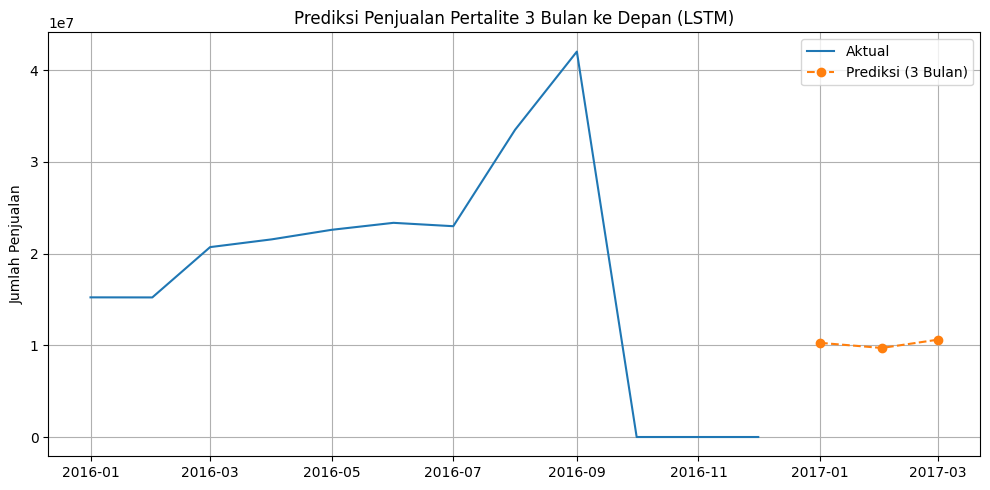

In [14]:
# 10.Visualisasi Prediksi
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
forecast_df = pd.DataFrame({'Forecast': forecast.flatten()}, index=forecast_dates)

# Gabungkan data terakhir dan prediksi
combined = pd.concat([data[-12:], forecast_df])

plt.figure(figsize=(10,5))
plt.plot(combined.index, combined['jumlah_penjualan'], label='Aktual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Prediksi (3 Bulan)', linestyle='--', marker='o')
plt.title('Prediksi Penjualan Pertalite 3 Bulan ke Depan (LSTM)')
plt.ylabel('Jumlah Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluasi Model LSTM

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data untuk uji: 3 bulan terakhir sebelum prediksi
X_train, y_train = X[:-3], y[:-3]
X_test, y_test = X[-3:], y[-3:]

# Prediksi untuk data uji
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Hitung error
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
📊 MAE: 17594399.33
📊 RMSE: 17935242.37


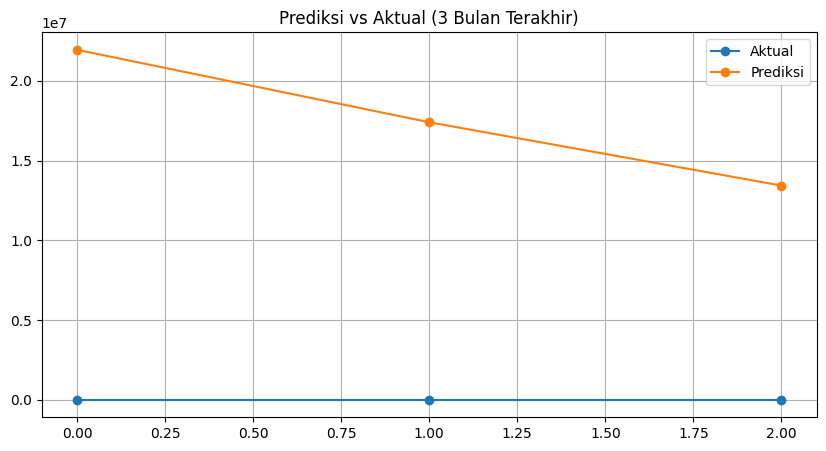

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_true, label='Aktual', marker='o')
plt.plot(y_pred, label='Prediksi', marker='o')
plt.title('Prediksi vs Aktual (3 Bulan Terakhir)')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0165 - val_loss: 0.2043
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0161 - val_loss: 0.2062
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0154 - val_loss: 0.2092
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0146 - val_loss: 0.2132
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0137 - val_loss: 0.2183
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0127 - val_loss: 0.2242
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0119 - val_loss: 0.2310
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0112 - val_loss: 0.2384
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0106 - val_loss: 0.2462
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0102 - val_loss: 0.2541
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.0099 - val_loss: 0.2617
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.009

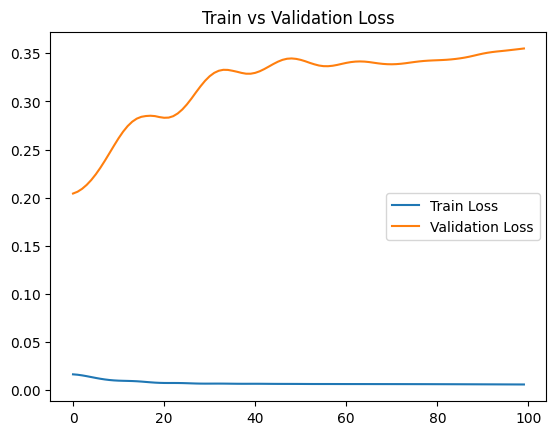

In [17]:
history = model.fit(X, y, epochs=100, validation_split=0.2)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()


In [18]:
# Simpan model dengan format baru
model.save('model_lstm_pertalite.keras')